In [1]:
from sklearn.datasets import make_moons, make_swiss_roll
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from functools import partial

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [118]:
def make_checkboard(num_samples):
    x2 = np.random.rand(10000,2)

    x2[(x2[:,0] // 0.25 + x2[:,1] // 0.25) %2 == 0,0] +=  0.25
    x2[x2 > 1.0] -= 1
    x2 -= [0.5,0.5]
    x2 *= 2
    return x2


In [119]:
# X1 = make_moons(5000)[0]
# swiss_roll = make_swiss_roll(5000)[0]
# X0 = np.stack((swiss_roll[:,0],swiss_roll[:,2]),axis=1) 

# X0 = (X0-X0.mean(axis=0,keepdims=True))/X0.std(axis=0,keepdims=True)
# X1 = (X1-X1.mean(axis=0,keepdims=True))/X1.std(axis=0,keepdims=True)

X0 = np.random.randn(5000,2)
X1  = make_checkboard(5000)

X0 = torch.from_numpy(X0).to(dtype=torch.float32,device=device)
X1 = torch.from_numpy(X1).to(dtype=torch.float32,device=device)

In [4]:
def rectified_interpolant(x0,x1,t):
    return (1-t)*x0 + t*x1


def independent_coupling(x0,x1,t,path_std):
    return (1-t)*x0 + t*x1 + torch.randn_like(x0)*path_std

def rectified_vector(xt,x0,x1,t):
    return x1-x0

In [5]:
def trigonometric_interpolant(x0,x1,t):
    return torch.cos(0.5*np.pi*t)*x0 + torch.sin(0.5*np.pi*t)*x1

def trigonometric_vector(xt,x0,x1,t):
    return 0.5*np.pi*(-torch.sin(0.5*np.pi*t)*x0 + torch.cos(0.5*np.pi*t)*x1)

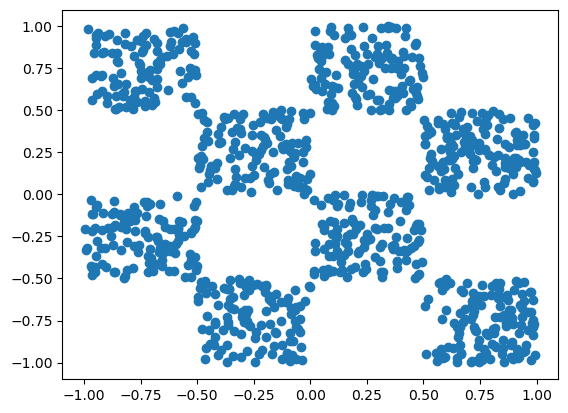

In [140]:
plt.scatter(X1[:1000,0].detach().cpu(),X1[:1000,1].detach().cpu())

In [9]:
def get_encodings(x,num_freq): #encoding used in NeRF
    encoded = [x]
    for i in range(num_freq):
        encoded.append(torch.sin(2**i*torch.pi*x))
        encoded.append(torch.cos(2**i*torch.pi*x))
    return torch.cat(encoded,dim=-1)

def get_t_encodings(t,num_freqs):
    
    enc = torch.full((t.shape[0],num_freqs*2+1),2,dtype=torch.float32).to(device)
    p = torch.arange(num_freqs)[None,:].to(device)
    enc[:,1:num_freqs+1] = (enc[0,:num_freqs]**p)[:,None,:]*t*np.pi
    enc[:,num_freqs+1:] = enc[:,1:num_freqs+1]
    enc[:,1:num_freqs+1] = torch.sin(enc[:,1:num_freqs+1])
    enc[:,num_freqs+1:] = torch.cos(enc[:,num_freqs+1:])
    enc[:,0] = t[:,0]
    return enc

## Sinkhorn Entropic OT-solver

In [154]:
def sinkhorn_ot(a,b,M,reg=0.01,max_iter=100,eps=0.005,device=torch.device('cuda')):
    log_a = torch.log(a.flatten()).to(device)
    log_b = torch.log(b.flatten()).to(device)
    
    log_v = torch.zeros_like(b).to(device)
    prev_log_v = log_v.clone()
    
    log_K = -M / reg
    
    for i in range(max_iter):
        prev_log_v = log_v.clone()
        
        log_u = log_a - torch.logsumexp(log_K+log_v,1)
        log_v = log_b - torch.logsumexp(log_K.t()+log_u,1)
        
        if torch.abs(prev_log_v - log_v).mean() <eps:
            break
            
    return (log_u.unsqueeze(1) +log_K+log_v.unsqueeze(0)).exp()


In [121]:
num_hid_layers = 3
num_freq = 5
model = nn.Sequential(
        nn.Linear(2+num_freq*2+1,128),
        nn.ReLU(),
        *[m for _ in range(num_hid_layers) for m in (nn.Linear(128, 128), nn.ReLU())],
        nn.Linear(128,2)
)   

model = model.to(device)

In [122]:
use_OT = True

if use_OT:
    M = torch.cdist(X0,X1)
    a = torch.full((X0.shape[0],), 1/X0.shape[0])
    b = torch.full((X1.shape[0],), 1/X1.shape[0])

    T = sinkhorn_ot(a,b,M,reg=0.05,device=device)


In [123]:
print_every = 20
learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
num_epoch = 5000
mb_size = 1024
loss_func = torch.nn.MSELoss()


interpolant = partial(independent_coupling,path_std=0.02)
cond_vec_field = rectified_vector
for e in range(num_epoch):
    if e%print_every == 0:
        acc_loss = 0
    for b in range(len(X0)//mb_size + 1):
        x0_ind = torch.randint(0,len(X0),(mb_size,))
        x1_ind = torch.randint(0,len(X1),(mb_size,))
        
        if use_OT:
            x1_ind = torch.multinomial(T[x0_ind],1).flatten()

        x0 = X0[x0_ind]
        x1 = X1[x1_ind]

        rand_time = torch.rand((mb_size,1),device=device)
        enc_rand_time = get_t_encodings(rand_time,num_freq)
        xt = interpolant(x0,x1,rand_time) 

        cvf_target = cond_vec_field(xt,x0,x1,rand_time)
        vec_pred = model(torch.concat((xt,enc_rand_time),axis=1))

        optimizer.zero_grad()
        loss = loss_func(cvf_target.detach(),vec_pred)
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
    if e%print_every == 0:
        print(f"epoch:{e} loss: {acc_loss/(b*print_every)}")
    
    

epoch:0 loss: 0.014301791414618492
epoch:20 loss: 0.0040925782173872
epoch:40 loss: 0.003711947426199913
epoch:60 loss: 0.0037093125749379395
epoch:80 loss: 0.003492375835776329
epoch:100 loss: 0.003378925286233425
epoch:120 loss: 0.0035196094308048488
epoch:140 loss: 0.0033229815308004618
epoch:160 loss: 0.0031005858909338713
epoch:180 loss: 0.0033400421496480705
epoch:200 loss: 0.003164953086525202
epoch:220 loss: 0.0032151269260793924
epoch:240 loss: 0.003327723126858473
epoch:260 loss: 0.0034968385938555003
epoch:280 loss: 0.00330876843072474
epoch:300 loss: 0.0033047948963940144
epoch:320 loss: 0.0032374805770814417
epoch:340 loss: 0.0032020834740251304
epoch:360 loss: 0.0030564161483198405
epoch:380 loss: 0.0030920937191694976
epoch:400 loss: 0.003306740801781416
epoch:420 loss: 0.003358445130288601
epoch:440 loss: 0.0032095721922814845
epoch:460 loss: 0.003158676018938422
epoch:480 loss: 0.003150041913613677
epoch:500 loss: 0.0033951258286833764
epoch:520 loss: 0.003224244108423

epoch:4300 loss: 0.00313558429479599
epoch:4320 loss: 0.003058779472485185
epoch:4340 loss: 0.003040232649073005
epoch:4360 loss: 0.003279660502448678
epoch:4380 loss: 0.002969817351549864
epoch:4400 loss: 0.0031192520167678595
epoch:4420 loss: 0.0031389206647872924
epoch:4440 loss: 0.003231189493089914
epoch:4460 loss: 0.0031973855104297398
epoch:4480 loss: 0.0031092511489987373
epoch:4500 loss: 0.002985433302819729
epoch:4520 loss: 0.003194224648177624
epoch:4540 loss: 0.0030866798479110003
epoch:4560 loss: 0.002824480691924691
epoch:4580 loss: 0.0031012821942567824
epoch:4600 loss: 0.0030653301626443865
epoch:4620 loss: 0.0031533028930425646
epoch:4640 loss: 0.002969684498384595
epoch:4660 loss: 0.0032319576013833283
epoch:4680 loss: 0.0030917408876121044
epoch:4700 loss: 0.00299644717015326
epoch:4720 loss: 0.002943931519985199
epoch:4740 loss: 0.0030341433826833963
epoch:4760 loss: 0.0029046212323009966
epoch:4780 loss: 0.002967163221910596
epoch:4800 loss: 0.0029364800080657004
e

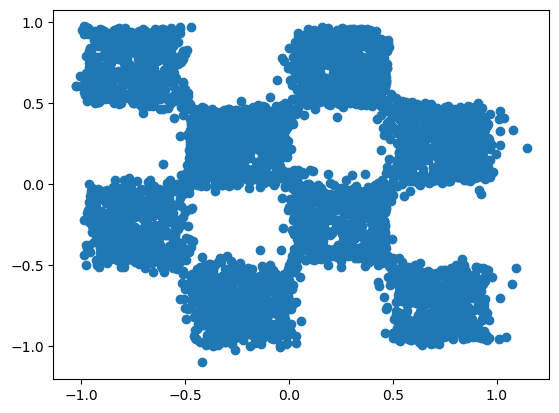

In [148]:
num_time_steps = 10
num_test_samples = 5000
start_t = 0.0
end_t = 1.0-start_t

step_size = (end_t-start_t)/num_time_steps

X1_test = make_moons(num_test_samples)[0]
swiss_roll = make_swiss_roll(num_test_samples)[0]
X0_test = np.stack((swiss_roll[:,0],swiss_roll[:,2]),axis=1) 

X0_test = (X0_test-X0_test.mean(axis=0,keepdims=True))/X0_test.std(axis=0,keepdims=True)
X1_test = (X1_test-X1_test.mean(axis=0,keepdims=True))/X1_test.std(axis=0,keepdims=True)

X0_test = np.random.randn(num_test_samples,2)
X1_test = make_checkboard(num_test_samples)

X0_test = torch.from_numpy(X0_test).to(dtype=torch.float32,device=device)
X1_test = torch.from_numpy(X1_test).to(dtype=torch.float32,device=device)

if start_t == 1.0:
    xt_sample = X1_test[:num_test_samples].clone()
elif start_t == 0.0:
    xt_sample = X0_test[:num_test_samples].clone()
    
    
xts = []
t = torch.full((len(xt_sample),1),start_t).to(device)
for n in range(num_time_steps):
    xt_sample += step_size*model(torch.concat((xt_sample,get_t_encodings(t,num_freq)),axis=1))
    t += step_size
    xts.append(xt_sample.detach().cpu().clone())
plt.scatter(xt_sample[:,0].detach().cpu(),xt_sample[:,1].detach().cpu())

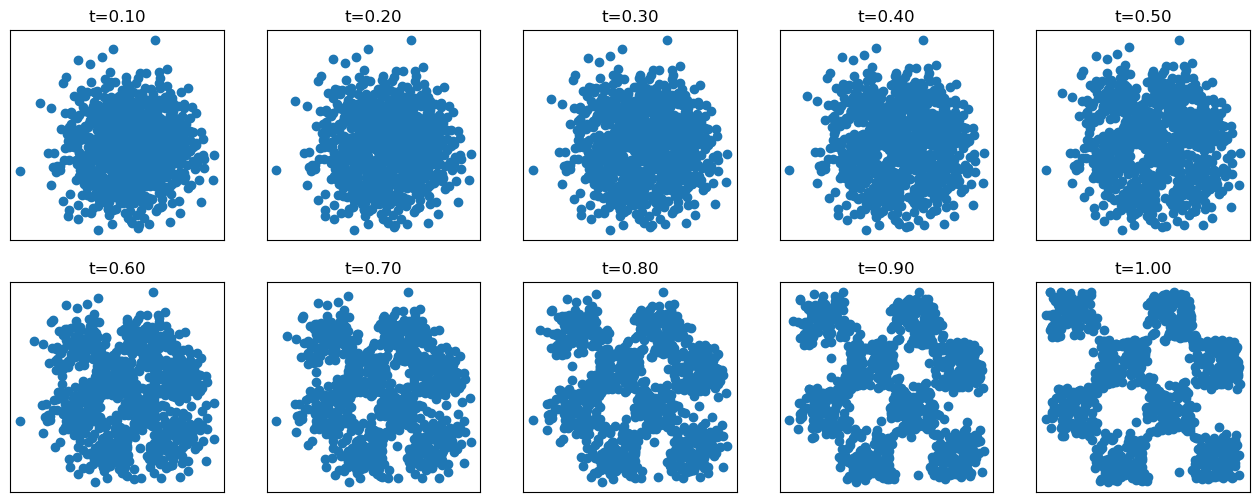

In [147]:
fig, axs = plt.subplots(2,5,figsize=(16,6))

for i in range(2):
    for j in range(5): 
        axs[i,j].scatter(xts[i*5+j][:1000,0].detach().cpu(),xts[i*5+j][:1000,1].detach().cpu())
        axs[i,j].set_title(f"t={(i*5+j)/10+0.1:.2f}")
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])


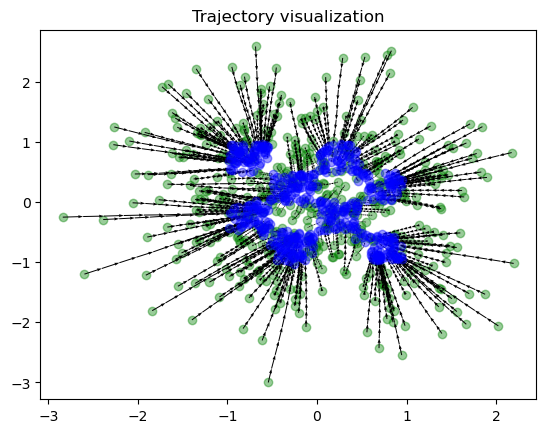

In [152]:
num_points = 500
for i in range(len(xts)):
    if i== 0:
        plt.scatter(xts[i][:num_points,0],xts[i][:num_points,1],c='g',alpha=0.4)
    if i==len(xts)-1:
        plt.scatter(xts[i][:num_points,0],xts[i][:num_points,1],c='b',alpha=0.4)
        continue
    plt.quiver(xts[i][:num_points,0],xts[i][:num_points,1],(xts[i+1]-xts[i])[:num_points,0],(xts[i+1]-xts[i])[:num_points,1],\
               scale=1,angles='xy',scale_units='xy',width=0.002)
    plt.title("Trajectory visualization")